In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH="data/prime_prove/"

In [ ]:
def get_folder_names(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

class Experiment:
    def __init__(self, name, path):
        self.name = name
        self.path = path
        self.color = None  # Placeholder for color, can be set later if needed
        # Data
        self.swap = None
        self.inference = None
        self.fps = None

    def load_csv(self, name):
        file_path = os.path.join(self.path, f"{name}.csv")
        if os.path.exists(file_path):
            return pd.read_csv(file_path)
        else:
            raise FileNotFoundError(f"Data file {file_path} does not exist.")
    def load_data(self):
        self.swap = self.load_csv("cpu_ram_swap")
        self.fps = self.load_csv("fps_status")
        self.inference = self.load_csv("inference_time")

class ExperimentManager:
    def __init__(self, data_path=DATA_PATH):
        self.data_path = data_path
        self.experiments = {}

    def init_all(self):
        folder_names = get_folder_names(self.data_path)
        for folder in folder_names:
            # Remove leading timestamp (assumes format: YYYYMMDD_HHMMSS_name)
            parts = folder.split('_', 2)
            if len(parts) == 3:
                exp_name = parts[2]
            else:
                exp_name = folder
            print(f"Loading experiment: {exp_name}")
            exp_path = os.path.join(self.data_path, folder)
            if os.path.isdir(exp_path):
                # Associa un colore di matplotlib
                color = plt.cm.tab10(len(self.experiments) % 10)
                experiment = Experiment(exp_name, exp_path)
                experiment.color = color
                experiment.load_data()
                self.experiments[exp_name] = experiment

    def get_experiment(self, name):
        return self.experiments.get(name)
    
    def plot_cpu_ram_swap(self):
        fig, axs = plt.subplots(3, 1, figsize=(12, 12))
        for name, exp in self.experiments.items():
            if exp.swap is not None:
                axs[0].plot(exp.swap['ID'], exp.swap['CPU_percent'], label=name, color=exp.color)
                axs[1].plot(exp.swap['ID'], exp.swap['RAM_percent'], label=name, color=exp.color)
                axs[2].plot(exp.swap['ID'], exp.swap[' SWAP_percent'], label=name, color=exp.color)

        axs[0].set_title('CPU Usage')
        axs[0].set_xlabel('Timestamp')
        axs[0].set_ylabel('CPU (%)')
        axs[0].grid(True)
        axs[0].legend()
        axs[0].set_ylim(10, 100)

        axs[1].set_title('RAM Usage')
        axs[1].set_xlabel('Timestamp')
        axs[1].set_ylabel('RAM (%)')
        axs[1].grid(True)
        axs[1].legend()
        axs[1].set_ylim(10, 100)

        axs[2].set_title('Swap Usage')
        axs[2].set_xlabel('Timestamp')
        axs[2].set_ylabel('Swap (%)')
        axs[2].grid(True)
        axs[2].legend()
        axs[2].set_ylim(10, 100)

        plt.tight_layout()
        plt.show()
    
    def plot_fps(self):
        plt.figure(figsize=(12, 6))
        for name, exp in self.experiments.items():
            if exp.fps is not None:
                plt.plot(exp.fps['ID'], exp.fps['FPS'], label=name, color=exp.color)

        plt.title('FPS Over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('FPS')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_inference_time(self):
        plt.figure(figsize=(10, 6))
        names = []
        values = []
        colors = []
        for name, exp in self.experiments.items():
            # Prendi il valore medio dell'inference time
            mean_val = exp.inference['Inference_Time'].mean()
            names.append(name)
            colors.append(exp.color)
            values.append(mean_val)
        plt.bar(names, values, color=colors)
        plt.title('Average Inference Time per Experiment')
        plt.xlabel('Experiment')
        plt.ylabel('Average Inference Time (ms)')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()
        

In [17]:
ExManager = ExperimentManager()
ExManager.init_all()

Loading experiment: local_tiny_quantized
Loading experiment: remote_tiny_quantized
Loading experiment: local_base_quantized


In [18]:
ex = ExManager.get_experiment("local_tiny_quantized")
ex.swap.head(), ex.inference.head(), ex.fps.head()

(   ID  CPU_percent  RAM_percent   SWAP_percent
 0   0         64.1         60.3           10.4
 1   1         90.4         60.7           10.4
 2   2         86.2         61.1           10.4
 3   3         89.4         61.5           10.2
 4   4         88.5         61.8           10.2,
    ID  Inference_Time
 0   0       72.947636,
    ID       FPS
 0   0  2.949670
 1   1  2.097073
 2   2  1.583508
 3   3  2.199197
 4   4  2.589606)

In [19]:
ex.swap.columns

Index(['ID', 'CPU_percent', 'RAM_percent', ' SWAP_percent'], dtype='object')

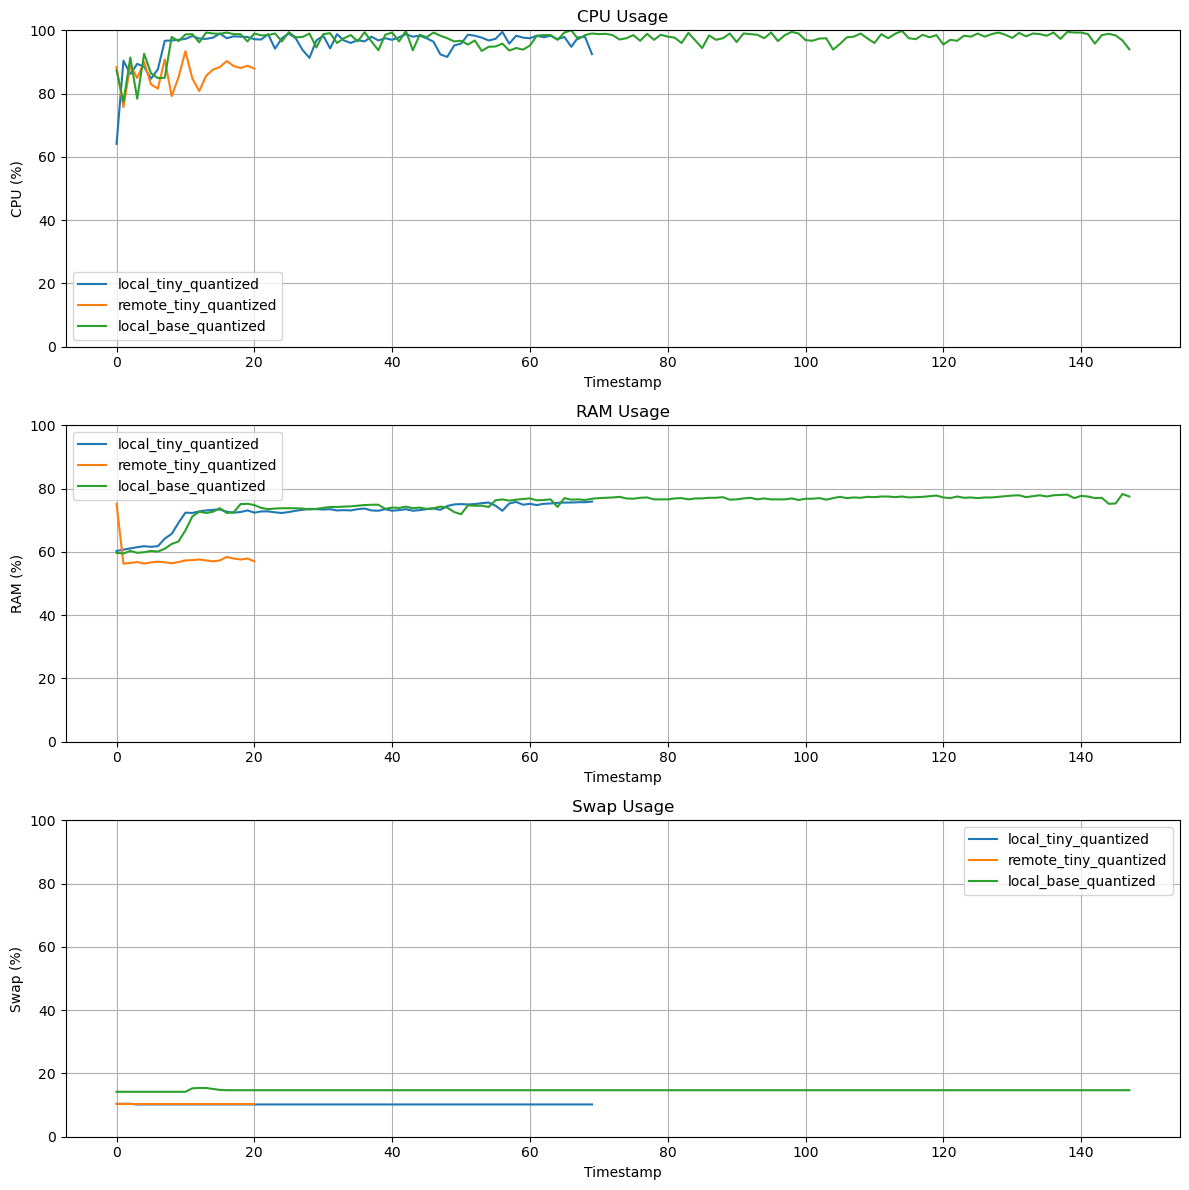

In [20]:
ExManager.plot_cpu_ram_swap()

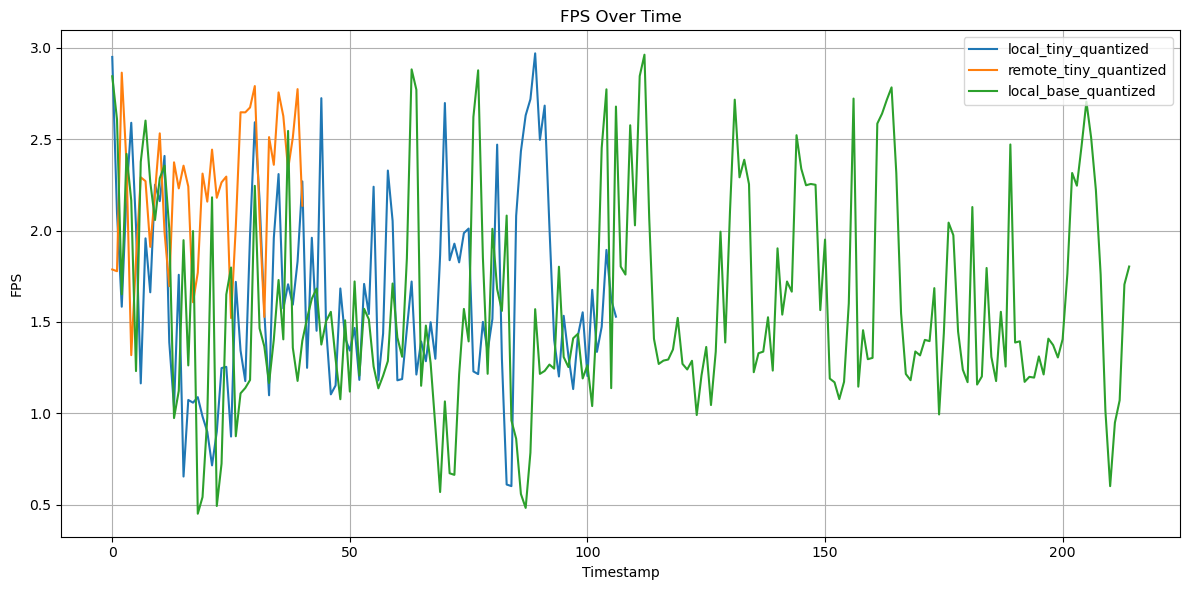

In [21]:
ExManager.plot_fps()

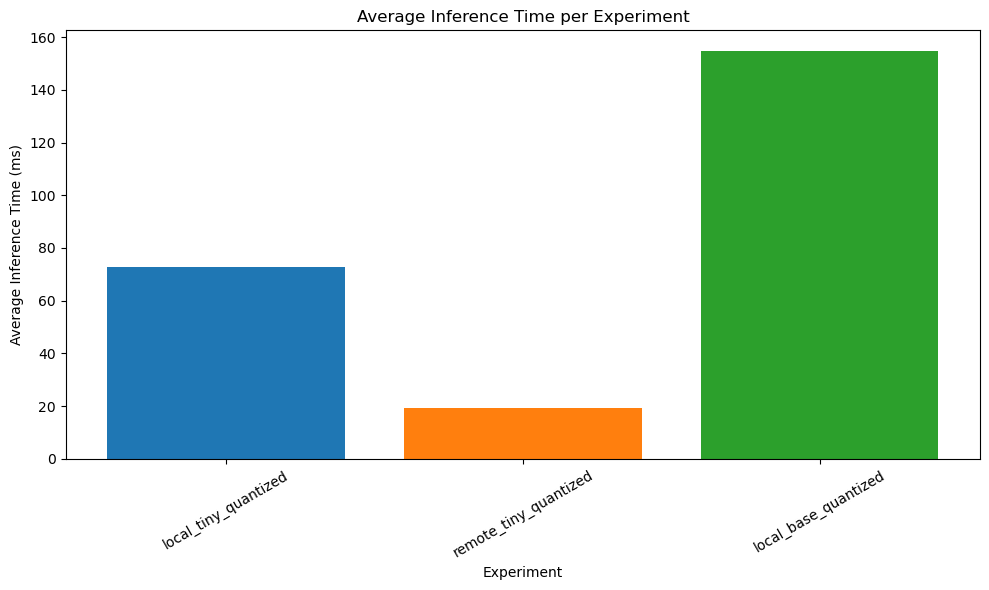

In [22]:
ExManager.plot_inference_time()